В этом notebook я по известной выборке $\mathbf{X}, \mathbf{y}$ получаю значения log-likelihood, mean и std.

# Imports

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
import scipy.stats as sps

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.size': 14,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

from utils import Dataset
from models import RegressionModel, LogisticModel

%load_ext autoreload
%autoreload 2

# Synthetic dataset (Regression)

$$ \mathbf{X} \in \mathbb{R}^{m \times n}, \quad \mathbf{y} \in \mathbb{R}^{m} $$

$$ p(\mathbf{y}, \mathbf{w}, \mathbf{X} | \alpha) = \prod_{i} \mathcal{N}(\mathbf{x}_i | \mathbf{0}, \sigma^2 \mathbf{I}_n) \mathcal{N}(\mathbf{w} | \mathbf{0}, \alpha^{-1} \mathbf{I}_n) \prod_{i} p(y_i | \mathbf{x}_j, \mathbf{w}) $$

$$ \mathbf{w} \in \mathbb{R}^{n} $$

$$ p(y_i | \mathbf{x}_i, \mathbf{w}) = \mathcal{N}(y_i | \mathbf{w}^\top \mathbf{x}_i,  1) $$

In [2]:
m = 1000
n = 20

In [3]:
alpha = 1
sigma = 2

In [4]:
X = sps.multivariate_normal(mean=np.zeros(n), cov=sigma**2*np.identity(n)).rvs(size=m)
w = sps.multivariate_normal(mean=np.zeros(n), cov=alpha**(-1)*np.identity(n)).rvs()
eps = sps.multivariate_normal(mean=np.zeros(m), cov=np.identity(m)).rvs()
y = X @ w + eps

In [7]:
dataset = Dataset(X, y)

In [8]:
X_train, X_test, y_train, y_test = dataset.train_test_split()

In [9]:
sample_sizes = np.arange(n, X_train.shape[0], 10) + 1

In [13]:
N = 10
llhs = [] # log-likelihoods

for m in sample_sizes:
    tmp = []
    for _ in range(N):
        X_m, y_m = Dataset(X_train, y_train).sample(m)
        model = RegressionModel(X_m, y_m, alpha=alpha)
        model_test = RegressionModel(X_test, y_test, alpha=alpha)
        w_hat = model.fit()
        tmp.append(model_test.loglikelihood(params=w_hat))
    tmp = np.array(tmp)
    llhs.append(tmp)

llhs = np.array(llhs)

In [14]:
llh_means = llhs.mean(axis=1)
llh_stds = llhs.std(axis=1)

Построим график зависимости логарифма правдоподобия, подсчитанного на тестовой выборке, от доступного объема обучающей выборки. Для каждого доступного объема обучающей выборки $m$ сгенерируем $N$ подвыборок обучающей выборки объема $m$ с возвращением (bootstrap). Усредним полученные результаты, откуда получим среднее значение и среднеквадратичное отклонение для каждого доступного объема обучающей выборки $m$. 

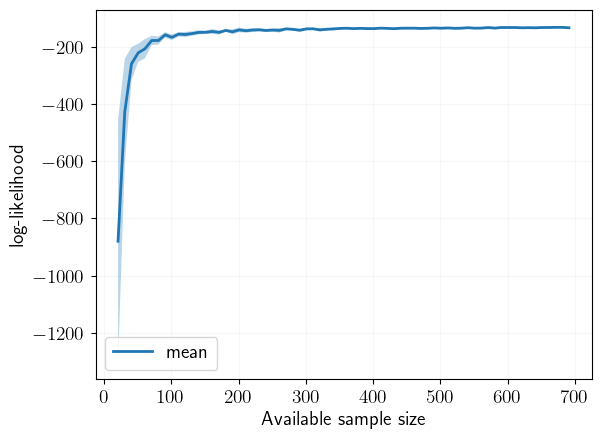

In [15]:
plt.plot(sample_sizes, llh_means, label='mean')
plt.fill_between(sample_sizes, llh_means - llh_stds, llh_means + llh_stds, alpha=0.3)

plt.legend()
plt.xlabel('Available sample size')
plt.ylabel('log-likelihood')
plt.show()

# Synthetic dataset (Classification)

$$ \mathbf{X} \in \mathbb{R}^{m \times n}, \quad \mathbf{y} \in \{-1, 1\}^m $$

$$ p(\mathbf{y}, \mathbf{w}, \mathbf{X} | \alpha) = \prod_{i} \mathcal{N}(\mathbf{x}_i | \mathbf{0}, \sigma^2 \mathbf{I}_n) \mathcal{N}(\mathbf{w} | \mathbf{0}, \alpha^{-1} \mathbf{I}_n) \prod_{i} p(y_i | \mathbf{x}_j, \mathbf{w}) $$

$$ \mathbf{w} \in \mathbb{R}^{n} $$

$$ p(y_i | \mathbf{x}_i, \mathbf{w}) = \sigma\left( y_i \mathbf{w}^\top \mathbf{x}_i \right) $$

In [277]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def prob_y(x, w):
    return sigmoid(x @ w)

def sample_y(X, w):
    return sps.bernoulli.rvs(p=prob_y(X, w))

In [278]:
m = 500
n = 20

In [279]:
alpha = 1
sigma = 2

In [280]:
X = sps.multivariate_normal(mean=np.zeros(n), cov=sigma**2*np.identity(n)).rvs(size=m)
w = sps.multivariate_normal(mean=np.zeros(n), cov=alpha**(-1)*np.identity(n)).rvs()
y = sample_y(X, w)

In [281]:
dataset = Dataset(X, y)

In [282]:
X_train, X_test, y_train, y_test = dataset.train_test_split()

In [283]:
sample_sizes = np.arange(n, X_train.shape[0], 10) + 1

In [296]:
N = 100
llhs_estimated = [] # log-likelihoods
llhs_genuine = []

for m in sample_sizes:
    tmp = []
    for _ in range(N):
        X_m, y_m = Dataset(X_train, y_train).sample(m)
        model = RegressionModel(X_m, y_m, alpha=alpha)
        model_test = RegressionModel(X_test, y_test, alpha=alpha)
        w_hat = model.fit()
        tmp.append(model_test.loglikelihood_fixed(params=w_hat))
    tmp = np.array(tmp)
    llhs_estimated.append(tmp)

llhs_estimated = np.array(llhs_estimated)

In [297]:
llh_means = llhs.mean(axis=1)
llh_stds = llhs.std(axis=1)

Построим график зависимости логарифма правдоподобия, подсчитанного на тестовой выборке, от доступного объема обучающей выборки. Для каждого доступного объема обучающей выборки $m$ сгенерируем $N$ подвыборок обучающей выборки объема $m$ с возвращением (bootstrap). Усредним полученные результаты, откуда получим среднее значение и среднеквадратичное отклонение для каждого доступного объема обучающей выборки $m$. 

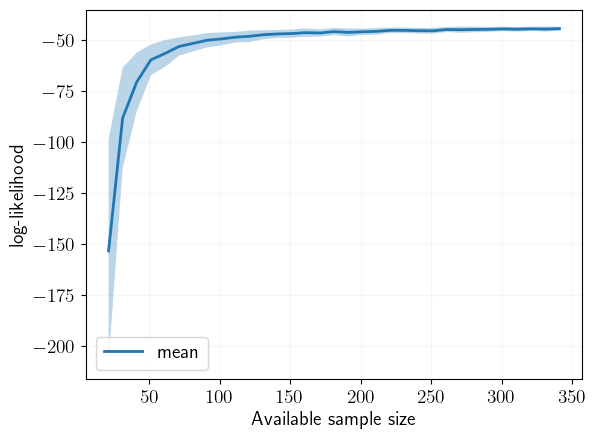

In [298]:
plt.plot(sample_sizes, llh_means, label='mean')
plt.fill_between(sample_sizes, llh_means - llh_stds, llh_means + llh_stds, alpha=0.3)

plt.legend()
plt.xlabel('Available sample size')
plt.ylabel('log-likelihood')
plt.show()